Klasifikasi Kucing & Anjing

Metode: CNN (VGG16 pretrained + custom classifier)

Fitur: TFDS (fallback), preprocessing, training, visualisasi, GUI upload gambar (ipywidgets)

In [9]:
!pip install -q tensorflow-datasets ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00


**Impor Library**

In [10]:
import os, random, shutil, io
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tampilkan versi
print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


# Dataset

mengunduh dataset gambar kucing dan anjing (cats_vs_dogs) secara otomatis dari TensorFlow Datasets (TFDS), kemudian membagi dataset menjadi data latih (80%) dan data validasi (20%), serta menyiapkan folder penyimpanan dataset di dalam direktori lokal. Dataset ini selanjutnya akan digunakan untuk melatih dan menguji model klasifikasi gambar.

In [11]:

WORK_DIR = "data_tfs_cats_dogs"
TRAIN_RAW = os.path.join(WORK_DIR, "train_raw")
VAL_RAW = os.path.join(WORK_DIR, "val_raw")
os.makedirs(TRAIN_RAW, exist_ok=True)
os.makedirs(VAL_RAW, exist_ok=True)

print("Mengunduh dataset cats_vs_dogs via TFDS (bisa memakan waktu beberapa menit)...")
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
print("Dataset TFDS didownload. Jumlah contoh (perkiraan):", ds_info.splits['train'].num_examples)

Mengunduh dataset cats_vs_dogs via TFDS (bisa memakan waktu beberapa menit)...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.Y8MN76_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset TFDS didownload. Jumlah contoh (perkiraan): 23262


**Penyimpanan Sampel Dataset Gambar ke Dalam Direktori Lokal**

In [12]:

def save_samples_from_tfds(ds, out_dir, limit=None, start_index=0):
    os.makedirs(out_dir, exist_ok=True)
    i = start_index
    for image, label in tfds.as_numpy(ds):
        img = Image.fromarray(image)
        label_str = "dog" if int(label)==1 else "cat"
        fname = f"{label_str}.{i}.jpg"
        img.save(os.path.join(out_dir, fname))
        i += 1
        if limit and i - start_index >= limit:
            break
    return i - start_index


print("Menyimpan sampel train (max 2400) dan val (max 800)...")
saved_train = save_samples_from_tfds(ds_train, TRAIN_RAW, limit=2400, start_index=0)
saved_val = save_samples_from_tfds(ds_val, VAL_RAW, limit=800, start_index=0)
print("Tersimpan - train:", saved_train, "val:", saved_val)

Menyimpan sampel train (max 2400) dan val (max 800)...
Tersimpan - train: 2400 val: 800


**Struktur Direktori dan Seleksi Data Training & Validasi**


Membuat ulang struktur folder dataset (train dan val) dengan subfolder cats dan dogs, kemudian mengambil, menyeleksi, dan mengacak file gambar kucing dan anjing dari folder data mentah. Langkah ini bertujuan untuk menyiapkan dataset yang rapi, seimbang, dan siap digunakan dalam proses pelatihan dan pengujian model klasifikasi gambar.

In [13]:
BASE_DIR = "data/cats_and_dogs_filtered"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")

# Hapus jika sudah ada (opsional untuk reset)
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
os.makedirs(os.path.join(TRAIN_DIR, "cats"), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, "dogs"), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, "cats"), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, "dogs"), exist_ok=True)

# Ambil file dari TRAIN_RAW & VAL_RAW
source_train_files = [f for f in os.listdir(TRAIN_RAW) if f.lower().endswith(('.jpg','.jpeg','.png'))]
source_val_files = [f for f in os.listdir(VAL_RAW) if f.lower().endswith(('.jpg','.jpeg','.png'))]

cats_files = [f for f in source_train_files if 'cat' in f.lower()]
dogs_files = [f for f in source_train_files if 'dog' in f.lower()]

# Jika jumlah tidak seimbang, tambahkan dari source_val_files
if len(cats_files) < 100 or len(dogs_files) < 100:
    cats_files += [f for f in source_val_files if 'cat' in f.lower()]
    dogs_files += [f for f in source_val_files if 'dog' in f.lower()]

print("Jumlah sumber cat:", len(cats_files), "dog:", len(dogs_files))

random.shuffle(cats_files)
random.shuffle(dogs_files)

Jumlah sumber cat: 1228 dog: 1172


**Menentukan Jumlah Data per Kelas dan Fungsi Penyalinan File Dataset**

menentukan jumlah maksimum data training dan validasi untuk setiap kelas (kucing dan anjing) secara seimbang, serta menyediakan fungsi untuk menyalin file gambar dari folder sumber ke folder tujuan. Tujuannya adalah agar dataset memiliki jumlah data yang proporsional dan siap digunakan dalam proses pelatihan model.

In [14]:
train_per_class = min(1000, len(cats_files), len(dogs_files))
val_per_class = min(400, max(0, len(cats_files)-train_per_class), max(0, len(dogs_files)-train_per_class))

# copy file (from TRAIN_RAW or VAL_RAW if not found)
def copy_if_exists(fname, src_dirs, dst_dir):
    for s in src_dirs:
        src_path = os.path.join(s, fname)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_dir)
            return True
    return False

**Pemindahan dan Pembagian Data Training dan Validasi Berdasarkan Kelas**

memindahkan file gambar kucing dan anjing ke dalam folder train dan val sesuai dengan jumlah yang telah ditentukan, sehingga setiap kelas memiliki data yang seimbang. Setelah proses pemindahan selesai, kode ini juga menampilkan jumlah data pada masing-masing folder untuk memastikan pembagian dataset sudah berhasil dan sesuai.

In [15]:
# Copy cats
for i, f in enumerate(cats_files[:train_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(TRAIN_DIR, "cats"))
for i, f in enumerate(cats_files[train_per_class:train_per_class+val_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(VAL_DIR, "cats"))

# Copy dogs
for i, f in enumerate(dogs_files[:train_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(TRAIN_DIR, "dogs"))
for i, f in enumerate(dogs_files[train_per_class:train_per_class+val_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(VAL_DIR, "dogs"))

print("Selesai memindahkan data.")
print(" - Train cats:", len(os.listdir(os.path.join(TRAIN_DIR,"cats"))))
print(" - Train dogs:", len(os.listdir(os.path.join(TRAIN_DIR,"dogs"))))
print(" - Val cats:", len(os.listdir(os.path.join(VAL_DIR,"cats"))))
print(" - Val dogs:", len(os.listdir(os.path.join(VAL_DIR,"dogs"))))


Selesai memindahkan data.
 - Train cats: 1000
 - Train dogs: 1000
 - Val cats: 172
 - Val dogs: 172


**Augmentasi Data dan Pembuatan Generator Data Training dan Validasi**

In [16]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 344 images belonging to 2 classes.


**Pembangunan dan Kompilasi Model CNN Berbasis VGG16**

membangun model klasifikasi gambar menggunakan VGG16 sebagai feature extractor (transfer learning) dengan membekukan seluruh layer bawaan VGG16 agar bobotnya tidak berubah saat training

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
EPOCHS = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 753ms/step - accuracy: 0.6751 - loss: 0.6131 - val_accuracy: 0.8576 - val_loss: 0.3163
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.8168 - loss: 0.3751 - val_accuracy: 0.8983 - val_loss: 0.2539
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.8683 - loss: 0.3154 - val_accuracy: 0.8983 - val_loss: 0.2270
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 452ms/step - accuracy: 0.8890 - loss: 0.2616 - val_accuracy: 0.8779 - val_loss: 0.2524
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 451ms/step - accuracy: 0.8979 - loss: 0.2477 - val_accuracy: 0.9244 - val_loss: 0.1932


**Visualisasi Hasil Training Model (Akurasi dan Loss)**

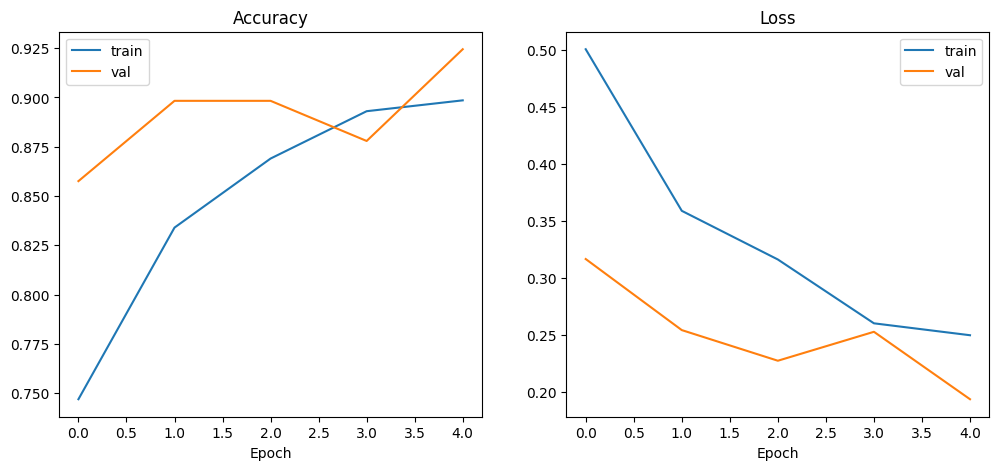

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train')
plt.plot(history.history.get('val_accuracy', []), label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train')
plt.plot(history.history.get('val_loss', []), label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [20]:
model.save("vgg16_cats_dogs_uts.h5")
print("Model tersimpan sebagai: vgg16_cats_dogs_uts.h5")

Model tersimpan sebagai: vgg16_cats_dogs_uts.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step
Confusion Matrix:
 [[98 74]
 [86 86]]


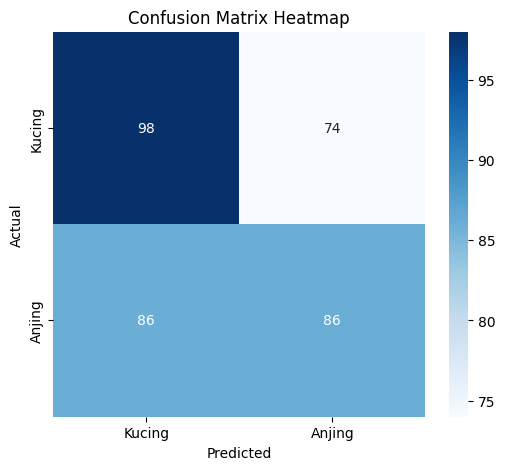

              precision    recall  f1-score   support

      Kucing       0.53      0.57      0.55       172
      Anjing       0.54      0.50      0.52       172

    accuracy                           0.53       344
   macro avg       0.54      0.53      0.53       344
weighted avg       0.54      0.53      0.53       344



In [21]:
# Prediksi pada validation set
val_generator.reset()  # pastikan urutan label tetap sama
Y_pred = model.predict(val_generator, verbose=1)
y_pred = (Y_pred > 0.5).astype(int)  # threshold sigmoid
y_true = val_generator.classes

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kucing', 'Anjing'],
            yticklabels=['Kucing', 'Anjing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Classification report (opsional)
print(classification_report(y_true, y_pred, target_names=['Kucing', 'Anjing']))


**Upload Gambar dan Prediksi Klasifikasi Kucing dan Anjing**

fitur upload gambar secara interaktif di Jupyter Notebook, menampilkan gambar yang diunggah, lalu melakukan prediksi otomatis menggunakan model CNN yang telah dilatih untuk menentukan apakah gambar tersebut merupakan kucing atau anjing. Hasil prediksi ditampilkan dalam bentuk kelas beserta nilai probabilitasnya, sehingga pengguna dapat langsung melihat hasil klasifikasi secara real-time.

In [24]:
from ipywidgets import FileUpload, Label, Output
from IPython.display import display
import matplotlib.pyplot as plt

upload = FileUpload(accept='image/*', multiple=False)
label = Label(value="Upload gambar kucing/anjing untuk prediksi")
output_img = Output()

def on_upload_change(change):
    if len(upload.value) == 0:
        return
    for name, file_info in upload.value.items():
        content = file_info['content']
        img = Image.open(io.BytesIO(content)).convert('RGB')

        # tampilkan gambar
        with output_img:
            output_img.clear_output(wait=True)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

        # preprocess & prediksi
        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        arr = np.array(img_resized)/255.0
        arr = np.expand_dims(arr, axis=0)

        pred = model.predict(arr)[0][0]
        if pred > 0.5:
            kelas = "Anjing 🐶"
        else:
            kelas = "Kucing 🐱"

        label.value = f"Prediksi: {kelas}    Probabilitas (sigmoid): {pred:.4f}"

upload.observe(on_upload_change, names='value')

display(label)
display(upload)
display(output_img)

Label(value='Upload gambar kucing/anjing untuk prediksi')

FileUpload(value={}, accept='image/*', description='Upload')

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [25]:
import io
import numpy as np
from PIL import Image
from ipywidgets import FileUpload, Label, Output, VBox
from IPython.display import display
import matplotlib.pyplot as plt

upload = FileUpload(accept='image/*', multiple=True)   # <= MULTIPLE TRUE
label = Label(value="Upload hingga 4 gambar kucing/anjing untuk prediksi")
output_img = Output()

def on_upload_change(change):
    files = upload.value

    if len(files) == 0:
        return

    with output_img:
        output_img.clear_output(wait=True)

        # Maksimal tampilkan 4 gambar
        max_images = min(4, len(files))

        plt.figure(figsize=(10, 10))

        i = 1
        for name, file_info in list(files.items())[:max_images]:
            content = file_info['content']
            img = Image.open(io.BytesIO(content)).convert('RGB')

            # Preprocess
            img_resized = img.resize((IMG_SIZE, IMG_SIZE))
            arr = np.array(img_resized) / 255.0
            arr = np.expand_dims(arr, axis=0)

            # Predict
            pred = model.predict(arr)[0][0]
            kelas = "Anjing 🐶" if pred > 0.5 else "Kucing 🐱"

            # Tampilkan gambar
            plt.subplot(2, 2, i)
            plt.imshow(img)
            plt.title(f"{kelas}\nProb: {pred:.4f}")
            plt.axis("off")
            i += 1

        plt.show()

upload.observe(on_upload_change, names='value')

display(VBox([label, upload, output_img]))
